In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [532]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

# Data Cleaning: Y-values

In [533]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

### Min-max scaling

In [534]:
def min_max_scaling(df, column_name='pv_measurement'):
    scaler = MinMaxScaler()
    df[column_name] = scaler.fit_transform(df[[column_name]])
    return df

train_a = min_max_scaling(train_a)
train_b = min_max_scaling(train_b)
train_c = min_max_scaling(train_c)

2019-10-01 00:00:00
2023-04-30 23:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


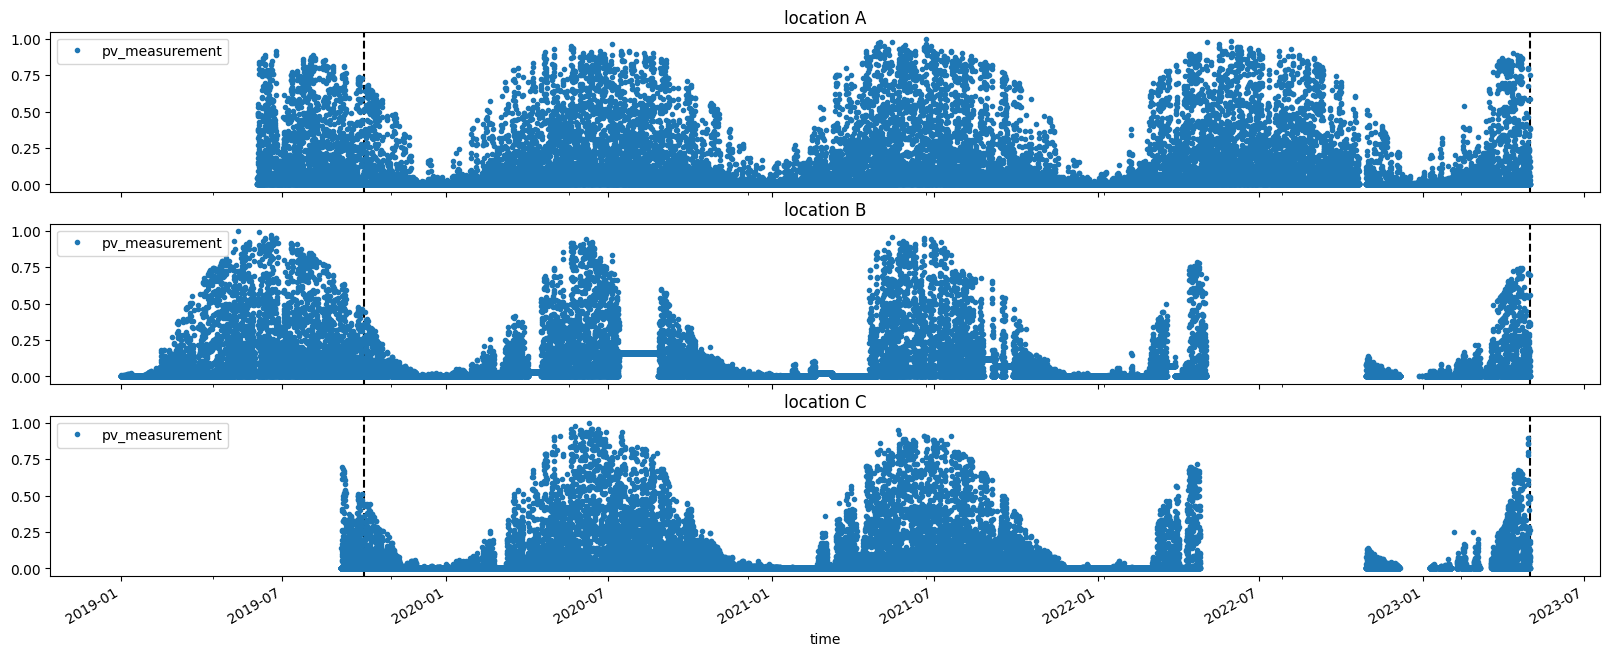

In [535]:
# Define the overall start and end dates
#overall_start = max(train_b.index.min(), train_c.index.min(), train_a.index.min())
overall_start = pd.Timestamp("2019-10-01 00:00:00")
overall_end = min(train_a.index.max(), train_b.index.max(), train_c.index.max())

print(overall_start)
print(overall_end)

print(type(overall_start))

fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)

# Add vertical lines to each subplot
for ax in axs:
    ax.axvline(overall_start, color="black", ls="--")
    ax.axvline(overall_end, color = "black", ls = "--")

#Plotting
train_a[['pv_measurement']].plot(ax=axs[0], title="location A", style=".")
train_b[['pv_measurement']].plot(ax=axs[1], title="location B", style=".")
train_c[['pv_measurement']].plot(ax=axs[2], title="location C", style=".")

plt.show()


In [536]:
# Create a complete date range
full_date_range = pd.date_range(start=overall_start, end=overall_end, freq='H')

# Reindexing
train_a = train_a.reindex(full_date_range)
train_b = train_b.reindex(full_date_range)
train_c = train_c.reindex(full_date_range)

<Axes: title={'center': 'location C'}>

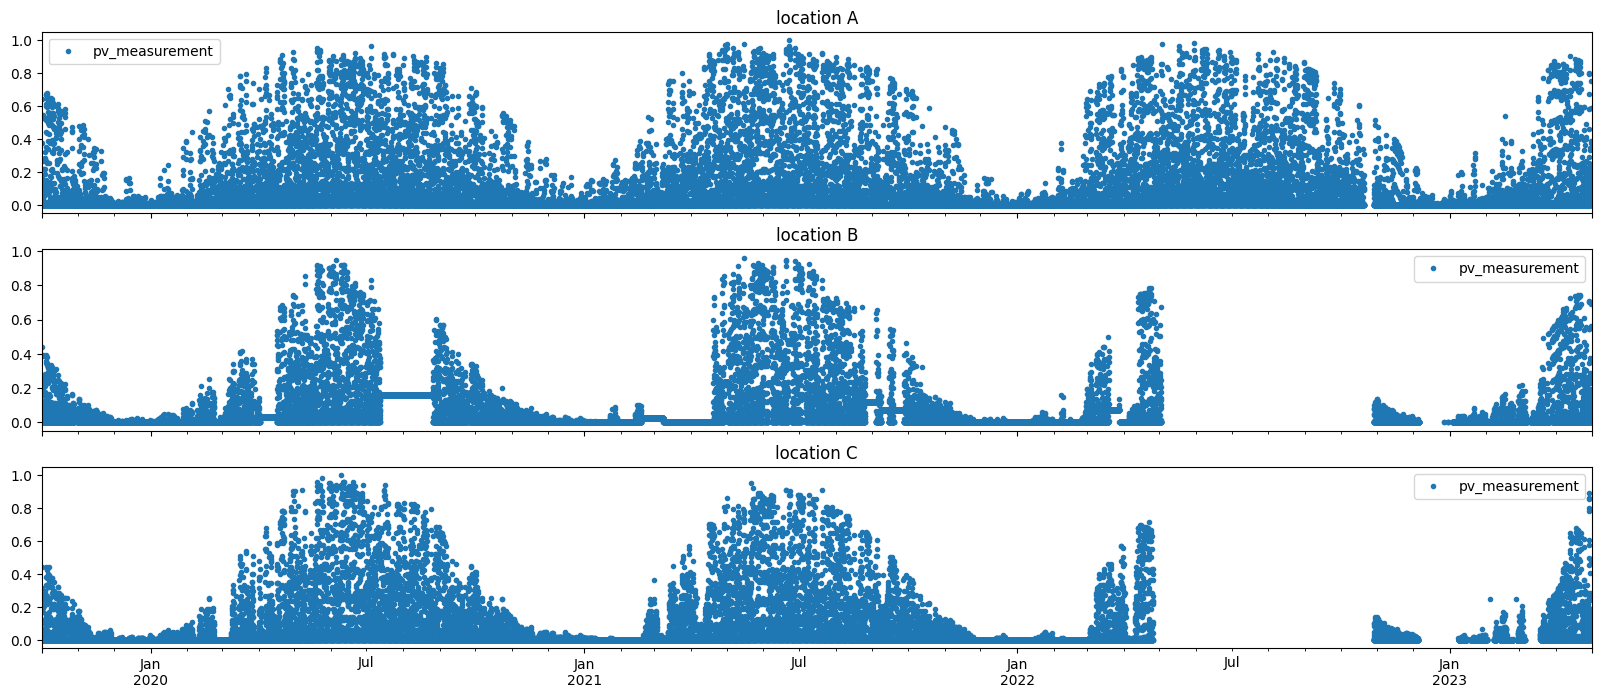

In [537]:
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
train_a[['pv_measurement']].plot(ax=axs[0], title="location A", style=".")
train_b[['pv_measurement']].plot(ax=axs[1], title="location B", style=".")
train_c[['pv_measurement', ]].plot(ax=axs[2], title="location C", style=".")

### Replace constants values with NaN

In [538]:
def replace_consecutive_identical_with_nan(dataframe):
    """
    Process the dataframe by replacing consecutive identical values with NaN.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to process.
    
    Returns:
    - pd.DataFrame: The processed dataframe.
    """
    # Create a mask where values are the same as the previous row
    mask = dataframe['pv_measurement'] == dataframe['pv_measurement'].shift(1)
    
    # Replace those values with NaN
    dataframe.loc[mask, 'pv_measurement'] = np.nan
    
    return dataframe

# Apply the function to each dataframe
train_a = replace_consecutive_identical_with_nan(train_a)
train_b = replace_consecutive_identical_with_nan(train_b)
train_c = replace_consecutive_identical_with_nan(train_c)

2019-10-01 00:00:00
2019-10-01 00:00:00
2019-10-01 00:00:00


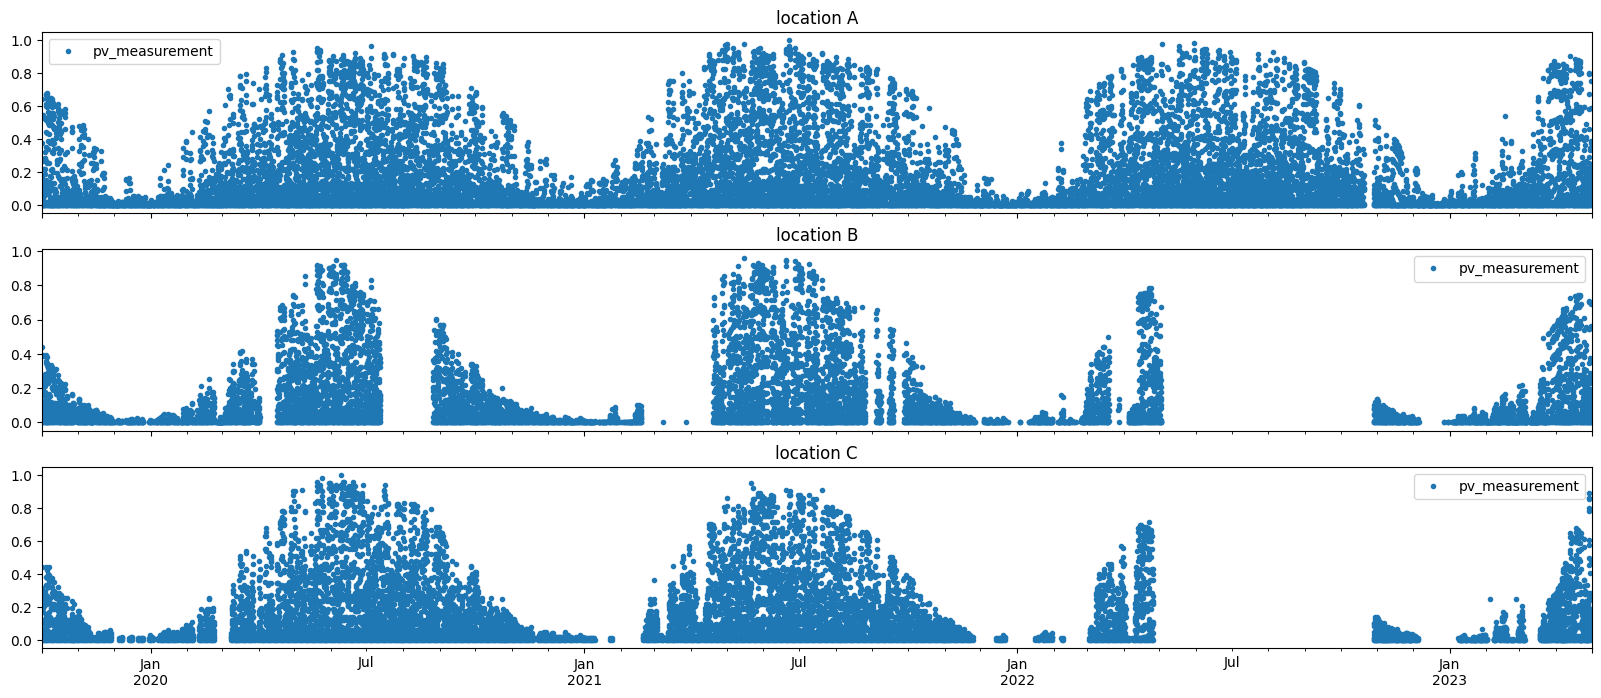

In [539]:
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
train_a[['pv_measurement']].plot(ax=axs[0], title="location A", style=".")
train_b[['pv_measurement']].plot(ax=axs[1], title="location B", style=".")
train_c[['pv_measurement', ]].plot(ax=axs[2], title="location C", style=".")

print(train_a.index.min())
print(train_b.index.min())
print(train_c.index.min())

### Replace missing values with NaN

In [540]:
def fill_missing_dates_in_dataframe(df, frequency='H'):
    """
    Fill missing dates in the index of a dataframe with NaN values.
    
    Parameters:
    - df (DataFrame): Input dataframe with a datetime index.
    - frequency (str): Frequency string to determine the date range (default is 'H' for hourly).
    
    Returns:
    - DataFrame with filled missing dates.
    """
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=frequency)
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    
    return pd.concat([df, missing_df]).sort_index()


train_b = fill_missing_dates_in_dataframe(train_b)
train_c = fill_missing_dates_in_dataframe(train_c)

## Replace NaN with Y-values from dataset A

In [541]:
def replace_nans_from_source(target_df, source_df):
    """
    Replace NaN values in the 'pv_measurement' column of the target dataframe using values 
    from the 'pv_measurement' column of the source dataframe.
    
    Args:
    - target_df (pd.DataFrame): The dataframe whose 'pv_measurement' NaN values need to be replaced.
    - source_df (pd.DataFrame): The dataframe which provides the 'pv_measurement' column for replacement.
    
    Returns:
    - pd.DataFrame: The target dataframe with NaN values replaced.
    """
    target_df['pv_measurement'] = target_df['pv_measurement'].combine_first(source_df['pv_measurement'])
    return target_df


# Use the function:
train_b = replace_nans_from_source(train_b, train_a)
train_c = replace_nans_from_source(train_c, train_a)

In [542]:
import pandas as pd

def merge_with_one_hot_encoding(dfs, names):
    """
    Merge a list of dataframes with one hot encoding to identify the source dataframe.
    
    Parameters:
    - dfs (list of DataFrames): List of dataframes to merge.
    - names (list of str): Names corresponding to each dataframe for one-hot encoding.
    
    Returns:
    - A merged dataframe with one-hot encoding columns.
    """
    # List to store dataframes after one-hot encoding
    encoded_dfs = []
    
    # Iterate over dataframes and names
    for df, name in zip(dfs, names):
        # Copy the dataframe to avoid modifying the original
        df_copy = df.copy()
        # Create a one-hot encoding column
        df_copy[name] = int(1)
        # Append to the list
        encoded_dfs.append(df_copy)
    
    # Concatenate all encoded dataframes
    merged_df = pd.concat(encoded_dfs, axis=0, sort=True).fillna(0)
    
    # Convert one-hot encoded columns back to integers
    for name in names:
        merged_df[name] = merged_df[name].astype(int)
    
    return merged_df

# Define the list of dataframes and their corresponding names
dfs = [train_a, train_b, train_c]
names = ["location_A", "location_B", "location_C"]

# Call the function
y_values_df = merge_with_one_hot_encoding(dfs, names)

# Drop the "location" column
y_values_df = y_values_df.drop("location", axis=1)

# Display the head of the merged dataframe
y_values_df.head()


,location_A,location_B,location_C,pv_measurement
2019-10-01 00:00:00,1,0,0,0.0
2019-10-01 01:00:00,1,0,0,0.0
2019-10-01 02:00:00,1,0,0,0.0
2019-10-01 03:00:00,1,0,0,0.0
2019-10-01 04:00:00,1,0,0,0.0


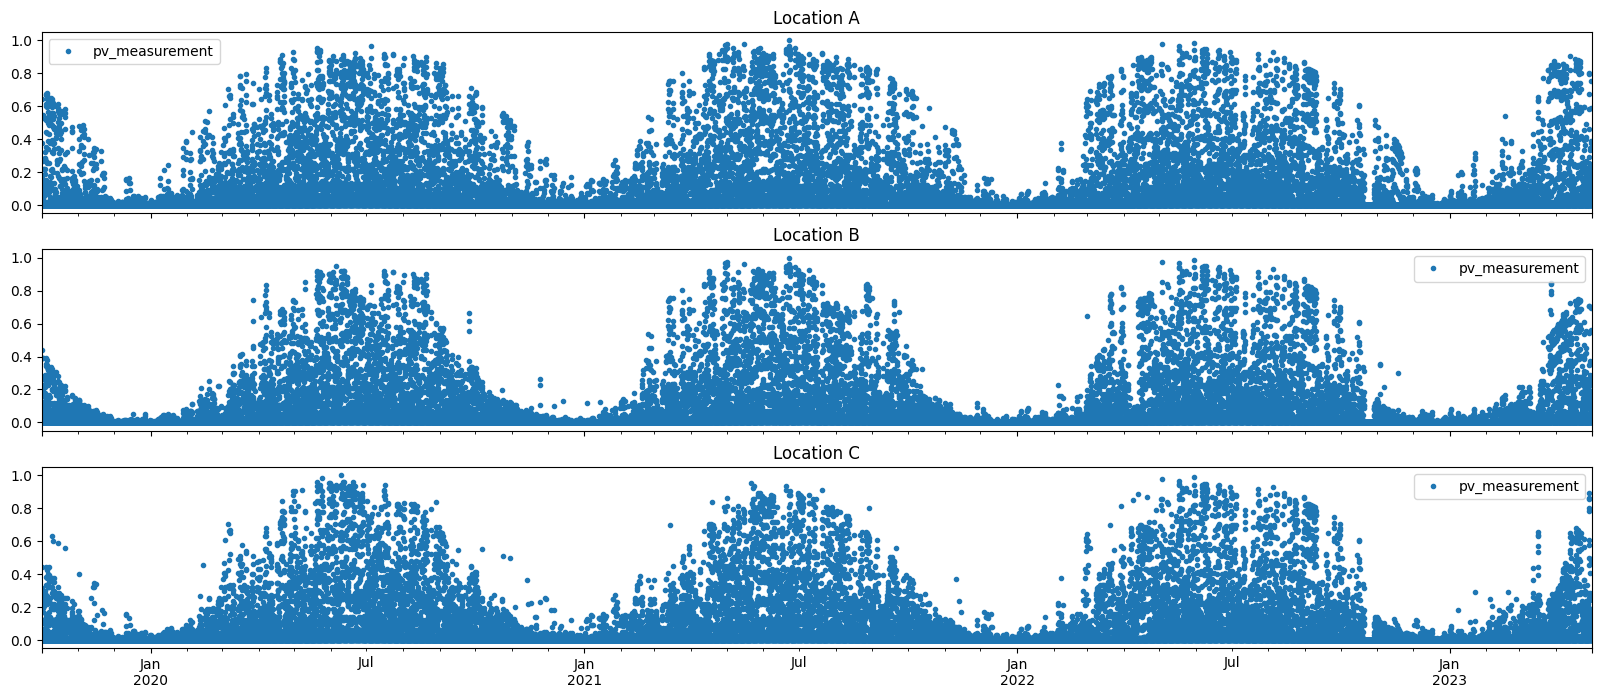

In [543]:
# Extract rows corresponding to each location
location_a = y_values_df.query('location_A == 1')
location_b = y_values_df.query('location_B == 1')
location_c = y_values_df.query('location_C == 1')

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(20,8), sharex=True)
location_a[['pv_measurement']].plot(ax=axs[0], title="Location A", style=".")
location_b[['pv_measurement']].plot(ax=axs[1], title="Location B", style=".")
location_c[['pv_measurement']].plot(ax=axs[2], title="Location C", style=".")

plt.show()


# Data Cleaning: X-values

### Set date_forecast as index and drop data_calc

In [544]:
all_x_train = [
    X_train_observed_a, 
    X_train_estimated_a, 
    X_train_observed_b, 
    X_train_estimated_b, 
    X_train_observed_c, 
    X_train_estimated_c
]

for df in all_x_train:
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.drop(columns="date_calc", errors="ignore", inplace=True)


### Concatenates two dataframes, adds missing date indices, and replaces NaN values

In [545]:
def concat_datasets(df1, df2):
    x = pd.concat([df1, df2], ignore_index=False)
    return x

def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

def fix_dataset(obs, est):
    x = concat_datasets(obs, est)
    x = add_missing_dates(x)
    x = x.combine_first(X_train_observed_a)
    return x

x_b = fix_dataset(X_train_observed_b, X_train_estimated_b)
x_c = fix_dataset(X_train_observed_c, X_train_estimated_c)

all_x_train = [X_train_observed_a, X_train_estimated_a, x_b, x_c]

### Resampling and Labeling DataFrames

In [546]:
# Resample all DataFrames to an hourly frequency
for i in range(len(all_x_train)):
    all_x_train[i] = all_x_train[i].resample('60min').sum()

# Separate combined DataFrames
X_train_observed_a, X_train_estimated_a, x_b, x_c = all_x_train

# Label data by location
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
x_b['location'] = 'B'
x_c['location'] = 'C'

# Label data by estimated/observed status
X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
x_b['estimated'], x_b.loc[x_b.index > X_train_estimated_b.index.min(), 'estimated'] = 0, 1
x_c['estimated'], x_c.loc[x_c.index > X_train_estimated_c.index.min(), 'estimated'] = 0, 1


### Combining DataFrames and One-hot Encoding

In [547]:
# Combine all DataFrames and sort by index
X = pd.concat(all_x_train, ignore_index=False)
X = X.sort_index()

# One-hot encode location information
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

# Merging Data

In [548]:
# Merge processed data with target data
df = pd.merge(y_values_df, X, left_on=[y_values_df.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

# Set and sort the index
df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

In [549]:
df.columns

Index(['location_A', 'location_B', 'location_C', 'pv_measurement',
       'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 

In [550]:
df.head()

,location_A,location_B,location_C,pv_measurement,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated
time,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00,1,0,0,0.0,20.100000,5.020,3186.600098,0.0,0.0,3186.600098,...,-112.084999,0.0,1108.800049,42.500000,123687.601562,8.8,-0.7,8.7,0.0,0
2019-10-01 00:00:00,0,1,0,0.0,20.100000,5.001,3189.800049,0.0,0.0,3189.800049,...,-112.084999,0.0,1108.800049,42.400002,133427.703125,8.8,-0.7,8.7,0.0,0
2019-10-01 00:00:00,0,0,1,0.0,19.200001,5.024,2740.600098,0.0,0.0,2740.600098,...,-112.231003,0.0,1108.400024,31.000000,123475.703125,7.6,-1.0,7.5,0.0,0
2019-10-01 01:00:00,0,0,1,0.0,18.799999,5.029,3132.800049,0.0,0.0,3132.800049,...,-99.283997,0.0,1106.900024,40.500000,121556.296875,7.5,-1.3,7.4,0.0,0
2019-10-01 01:00:00,1,0,0,0.0,19.600000,5.028,3644.800049,0.0,0.0,3644.800049,...,-99.158005,0.0,1107.000000,35.299999,117341.703125,8.7,-1.2,8.6,0.0,0


# Machine learning

In [551]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='time', y='pv_measurement')
plt.show()

KeyboardInterrupt: 

### Feature Engineering

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

df = create_features(df)

df.columns

Index(['location_A', 'location_B', 'location_C', 'pv_measurement',
       'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 

In [ ]:
df = df[[
    'sun_elevation:d',
    'effective_cloud_cover:p',
    
    'location_A', 
    'location_B', 
    'location_C',

    'hour', 
    'dayofweek', 
    'month', 
    'year',
]]

# XGBoost

In [ ]:
cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}

X_train = df[FEATURES]
y_train = df[TARGET]

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=2)
grid_search.fit(X_train, y_train)


NameError: name 'FEATURES' is not defined